In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
from statsmodels.stats.outliers_influence import summary_table

In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [7]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [8]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [9]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [10]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [11]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    
    plt.xlim(min(x),max(x))
    plt.ylim(min(y),max(y))
    
    
    plt.show()


In [12]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [13]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    font_size_this = 22
    ax.set_xlabel('|ΔVal|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)

    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    sns.despine()

In [14]:
def add_difficulty_TotVal(df,TotVal_label):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[[TotVal_label]].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [15]:
def plot_DEv_Conf_TotVal(data, TotVal_label, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df,TotVal_label)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)
    font_size_this = 22
    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣVal|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    sns.despine()

## Define some parameters for the simulations


In [16]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data and GLAM structure (Like & Dislike)
Used binned data for simulation.

In [17]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [18]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

---------------------------------------------------------
# Like condition


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [19]:
sufix = '_Like_NoBin_NUTS_31'
L_glam_full = glam.GLAM(data)
L_glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
L_glam_full.estimates = pd.DataFrame.from_dict(L_glam_full.estimates.item(0))
L_params_part = L_glam_full.estimates

In [20]:
L_params_part

,v_sd,v_mu,gamma_mu,tau_mu,t0,b,tau_sd,SNR,p_error,tau,gamma_sd,gamma,SNR_sd,v,s,SNR_mu
0,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,151.23,0.05,3.74,0.38,-0.11,35.54,0.000047,0.007843,164.29
1,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.71,0.05,4.30,0.38,0.29,35.54,0.000072,0.010344,164.29
2,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,141.48,0.05,2.59,0.38,-0.00,35.54,0.000058,0.008574,164.29
3,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,157.60,0.05,4.65,0.38,-0.10,35.54,0.000043,0.007178,164.29
4,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,96.58,0.05,4.22,0.38,-0.37,35.54,0.000080,0.007063,164.29
5,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,113.65,0.05,2.80,0.38,0.15,35.54,0.000059,0.008615,164.29
6,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,163.65,0.05,3.55,0.38,-0.00,35.54,0.000069,0.010656,164.29
7,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,150.49,0.05,3.29,0.38,-0.08,35.54,0.000045,0.007405,164.29
8,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,175.26,0.05,1.24,0.38,-0.71,35.54,0.000053,0.009622,164.29
9,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.66,0.05,4.77,0.38,-0.08,35.54,0.000048,0.007104,164.29


## Load like paramters for (human) confidence regression

In [21]:
%%R
# Fit the multilevel linear model
load('SavedModels_Regressions/HModel_Confidence_Like_31_m1.rda')   
print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')

confidence_Like_hmodel
mix_Confidence_Like_model <- coef(confidence_Like_hmodel)
mix_Confidence_Like_model

[1] "  Found old parameter estimates in \"SavedModels/estimates\". Skipping estimation..."
$Part
    (Intercept)    zAbsDVal          zRT      zTotVal        zGSF
1   0.077984322 0.089126710 -0.536070753 -0.055667285 -0.08476335
2  -0.010210458 0.146241690 -0.394922003  0.157151522 -0.11571808
3   0.045674016 0.183332053 -0.298155850  0.138753222 -0.05440732
4  -0.044331812 0.182682472 -0.519404909  0.189306119 -0.11956029
5  -0.127956604 0.151441505 -0.470905725  0.311234197 -0.06977023
8   0.130127988 0.178433961  0.017618498  0.121722425 -0.02140200
9   0.041012800 0.080733474 -0.316055498  0.067287220 -0.08381758
10  0.102116425 0.076374755 -0.283399533 -0.014605693 -0.09079814
11  0.055788777 0.120142670 -0.251551361  0.090457315 -0.12689963
12  0.184625163 0.202899397 -0.124947842  0.004696262 -0.08543122
13  0.054064331 0.072878045 -0.142552389  0.114589653  0.06330730
14  0.197524064 0.142747860 -0.284367519 -0.112267495 -0.12284097
15  0.155916684 0.007665127  0.059232518 -0.0

In [22]:
%R -o mix_Confidence_Like_model
# extract
mix_Confidence_Like_model = mix_Confidence_Like_model[0]
mix_Confidence_Like_model

(Intercept),zAbsDVal,zRT,zTotVal,zGSF
0.077984,0.089127,-0.536071,-0.055667,-0.084763
-0.010210,0.146242,-0.394922,0.157152,-0.115718
0.045674,0.183332,-0.298156,0.138753,-0.054407
-0.044332,0.182682,-0.519405,0.189306,-0.119560
...,...,...,...,...
0.011572,0.119033,-0.003659,0.244297,-0.059018
0.082429,0.047769,-0.320422,-0.008245,0.017001
0.180269,0.110832,-0.099273,-0.039274,-0.046361
0.026882,0.014363,-0.314452,0.058090,0.082045


In [23]:
#extract coeficients for zTotVal
LTotValCoefs = mix_Confidence_Like_model[3]

In [24]:
L_gamma_betaTotVal =  pd.DataFrame()
L_gamma_betaTotVal["Gamma"] = L_params_part.gamma
L_gamma_betaTotVal["Beta_TotVal"] = LTotValCoefs

Pearson's r = -0.257 p =  0.163


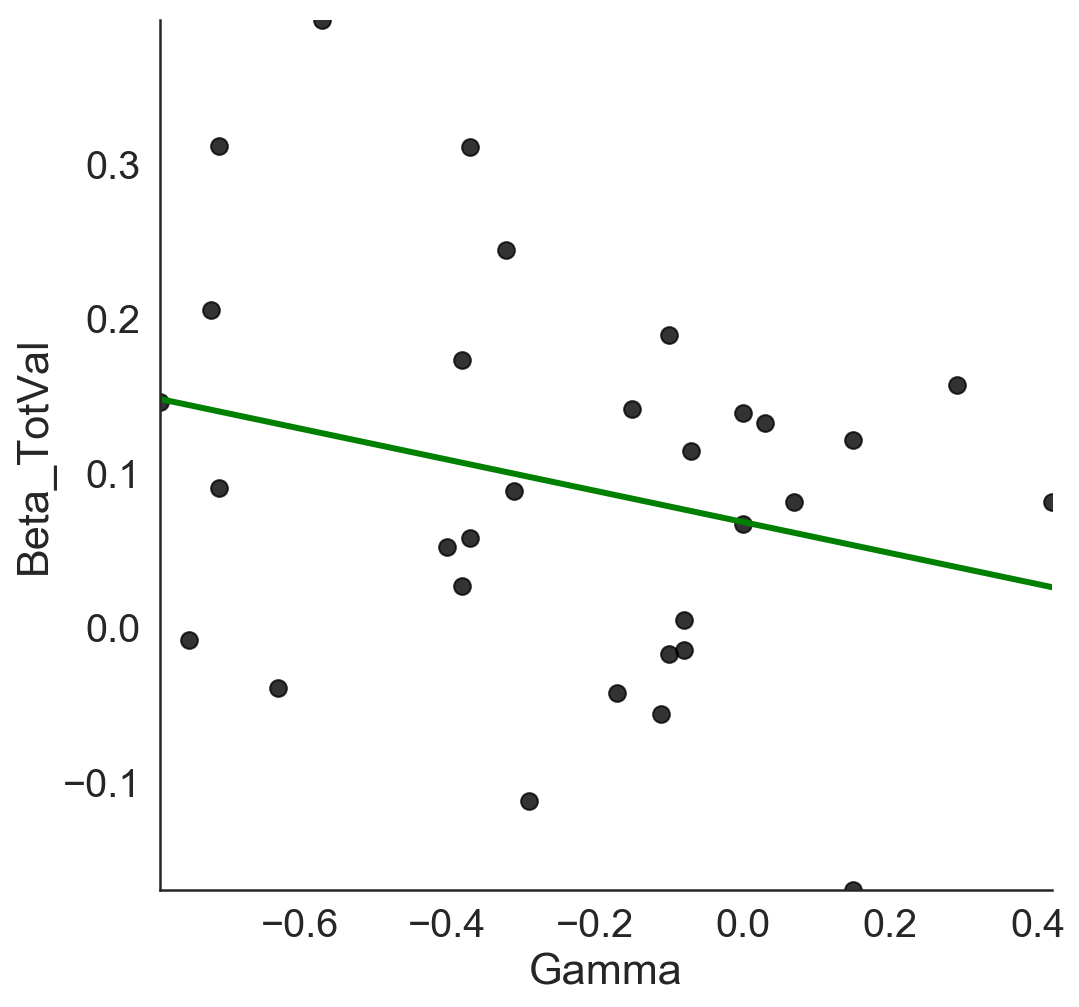

In [25]:
correl_plot(L_gamma_betaTotVal,'Gamma', "Gamma",'Beta_TotVal','Beta_TotVal')

# Dislike condition
----------------------------------------------------------------------------------

## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [26]:
sufix = '_Dislike_NoBin_Dislike_NUTS_Inv_31'
D_glam_full = glam.GLAM(data2)
D_glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
D_glam_full.estimates = pd.DataFrame.from_dict(D_glam_full.estimates.item(0))
D_params_part = D_glam_full.estimates

In [27]:
D_params_part

,gamma_mu,gamma,p_error,gamma_sd,tau_sd,v_mu,b,SNR_sd,v_sd,tau_mu,tau,t0,v,s,SNR_mu,SNR
0,-0.09,0.53,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000039,0.005929,186.55,175.47
1,-0.09,0.73,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.18,0.0,0.000050,0.010297,186.55,200.96
2,-0.09,0.97,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,0.93,0.0,0.000042,0.007670,186.55,159.54
3,-0.09,-0.05,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.92,0.0,0.000037,0.007801,186.55,178.00
4,-0.09,0.18,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.10,0.0,0.000050,0.009849,186.55,186.73
5,-0.09,0.27,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000047,0.008528,186.55,173.28
6,-0.09,0.21,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,1.81,0.0,0.000055,0.009641,186.55,145.49
7,-0.09,-0.09,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.79,0.0,0.000042,0.007573,186.55,159.34
8,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.15,0.0,0.000047,0.008367,186.55,160.79
9,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.68,0.0,0.000052,0.007714,186.55,124.54


## Load dislike paramters for (human) confidence regression

In [28]:
%%R
# Fit the multilevel linear model
load('SavedModels_Regressions/HModel_Confidence_Dislike_31_m1.rda')   
print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')

confidence_Dislike_hmodel
mix_Confidence_Dislike_model <- coef(confidence_Dislike_hmodel)
mix_Confidence_Dislike_model

[1] "  Found old parameter estimates in \"SavedModels/estimates\". Skipping estimation..."
$Part
     (Intercept)     zAbsDVal         zRT      zTotVal         zGSF
1  -1.080689e-01  0.171538075 -0.29904070 -0.156665404 -0.142662458
2  -2.786140e-02  0.168576650 -0.23836842 -0.118189818 -0.013496867
3  -3.766942e-05  0.216838268 -0.44112455  0.021673471  0.064027373
4  -3.397594e-02  0.244613982 -0.36444545 -0.102105526 -0.150714349
5   3.470724e-02  0.217504398 -0.35079159 -0.014110590 -0.177136186
8  -4.566054e-02  0.134632263 -0.22492913 -0.112923582 -0.043238147
9  -3.965740e-02  0.165991440 -0.33618395 -0.050734338 -0.034649497
10 -1.617216e-01  0.212642589 -0.21667787 -0.318882641 -0.122601543
11 -6.356421e-02  0.129322509 -0.41032932  0.019972604 -0.137549857
12 -1.691570e-01  0.237908218 -0.54051555 -0.096943988 -0.189511808
13 -1.901569e-01  0.180691020 -0.22852288 -0.306751313  0.069372563
14 -1.952727e-01  0.244393589 -0.28978065 -0.328235611 -0.105730368
15 -5.414966e-02 -0

In [29]:
%R -o mix_Confidence_Dislike_model
# extract
mix_Confidence_Dislike_model = mix_Confidence_Dislike_model[0]
mix_Confidence_Dislike_model

(Intercept),zAbsDVal,zRT,zTotVal,zGSF
-0.108069,0.171538,-0.299041,-0.156665,-0.142662
-0.027861,0.168577,-0.238368,-0.118190,-0.013497
-0.000038,0.216838,-0.441125,0.021673,0.064027
-0.033976,0.244614,-0.364445,-0.102106,-0.150714
...,...,...,...,...
-0.024544,0.117465,-0.066499,-0.198487,-0.045629
-0.069684,0.082775,-0.173460,-0.125971,-0.006207
-0.156437,-0.032222,-0.112720,-0.147589,0.048935
0.004763,-0.046368,0.039288,-0.085669,-0.033688


In [30]:
#extract coeficients for zTotVal
DTotValCoefs = mix_Confidence_Dislike_model[3]

In [31]:
D_gamma_betaTotVal =  pd.DataFrame()
D_gamma_betaTotVal["Gamma"] = D_params_part.gamma
D_gamma_betaTotVal["Beta_TotVal"] = DTotValCoefs

Pearson's r = -0.025 p =  0.895


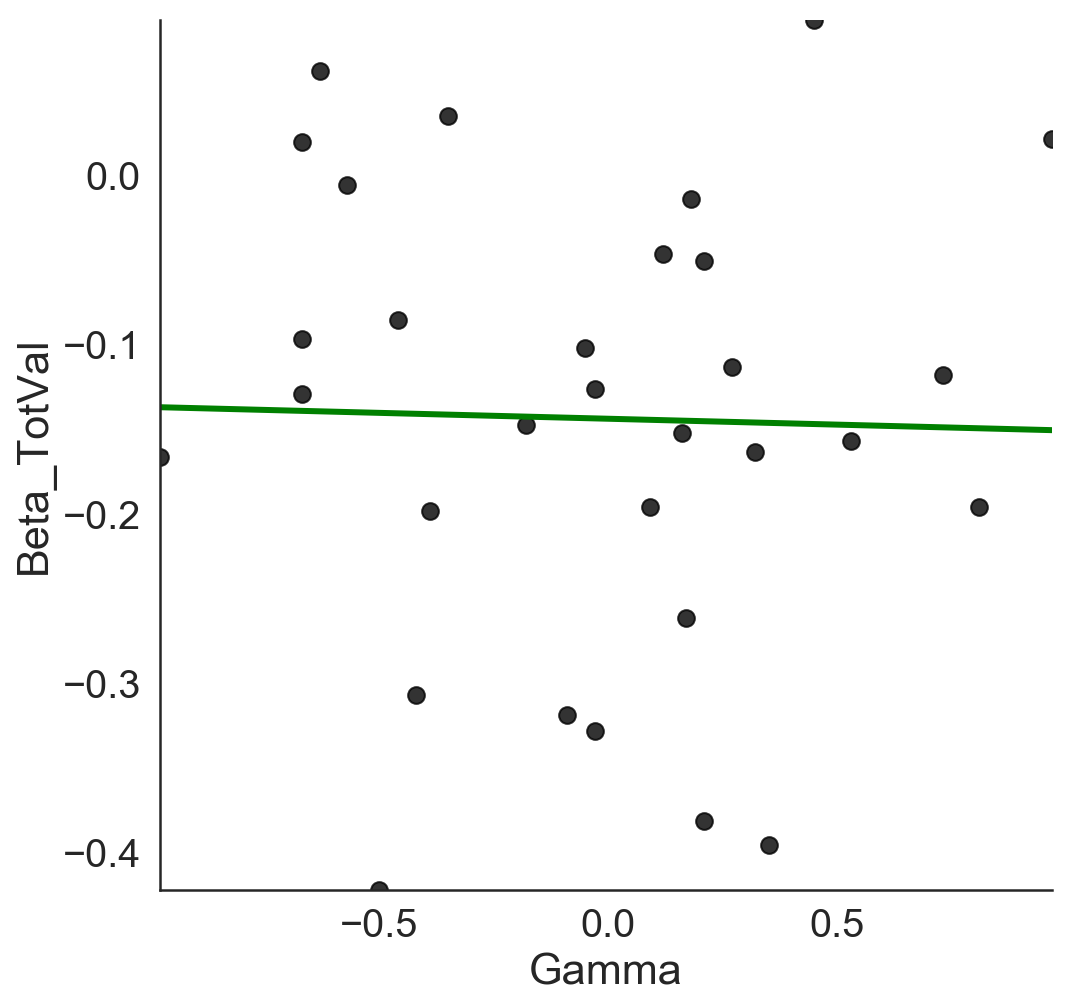

In [32]:
correl_plot(D_gamma_betaTotVal,'Gamma', "Gamma",'Beta_TotVal','Beta_TotVal')

---------------------------------------------------------

# Are the parameters maintained within participants for like and dislike ?

Pearson's r = 0.532 p =  0.002


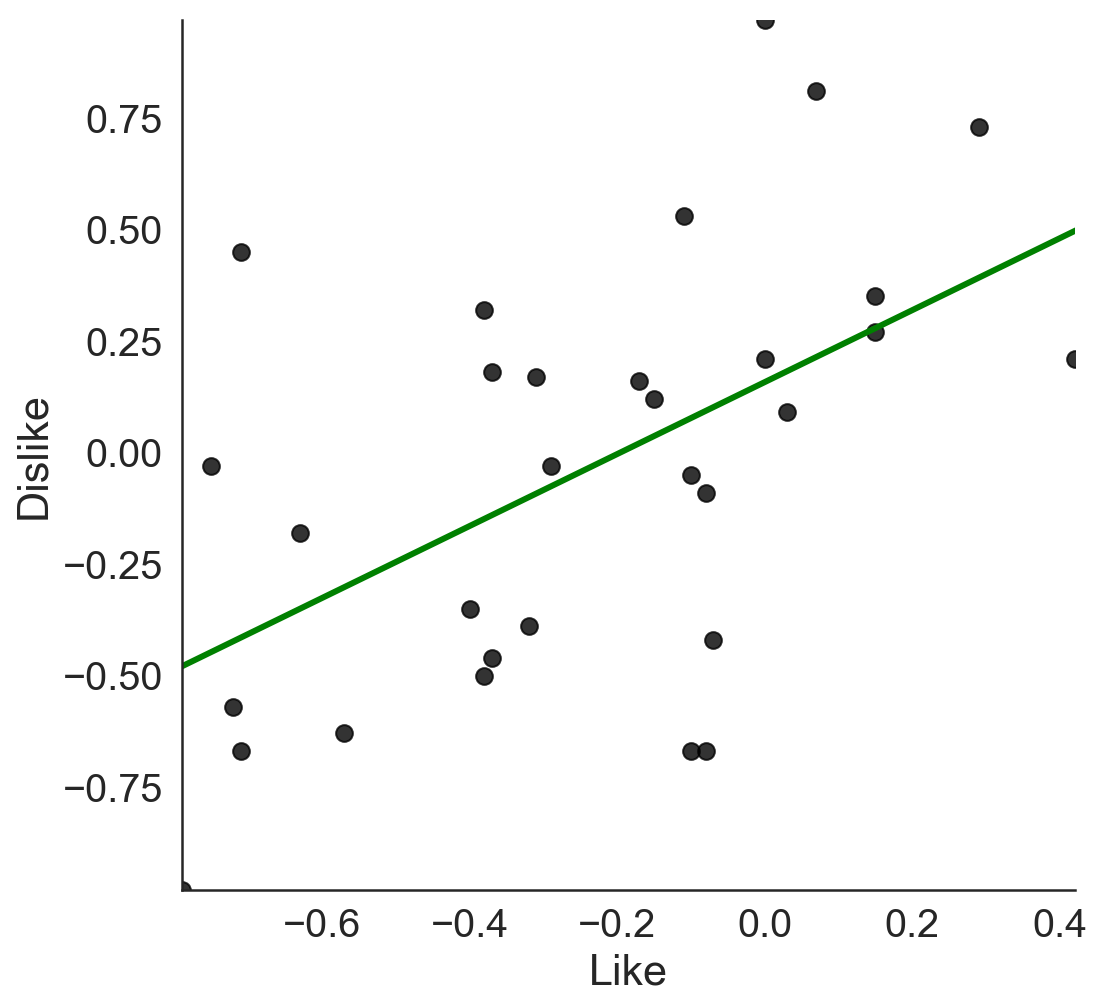

In [33]:
LD_Gamma =  pd.DataFrame()
LD_Gamma['Dislike'] =  D_params_part.gamma
LD_Gamma['Like'] =  L_params_part.gamma
correl_plot(LD_Gamma,'Like', "Like",'Dislike','Dislike')

Pearson's r = 0.265 p =  0.15


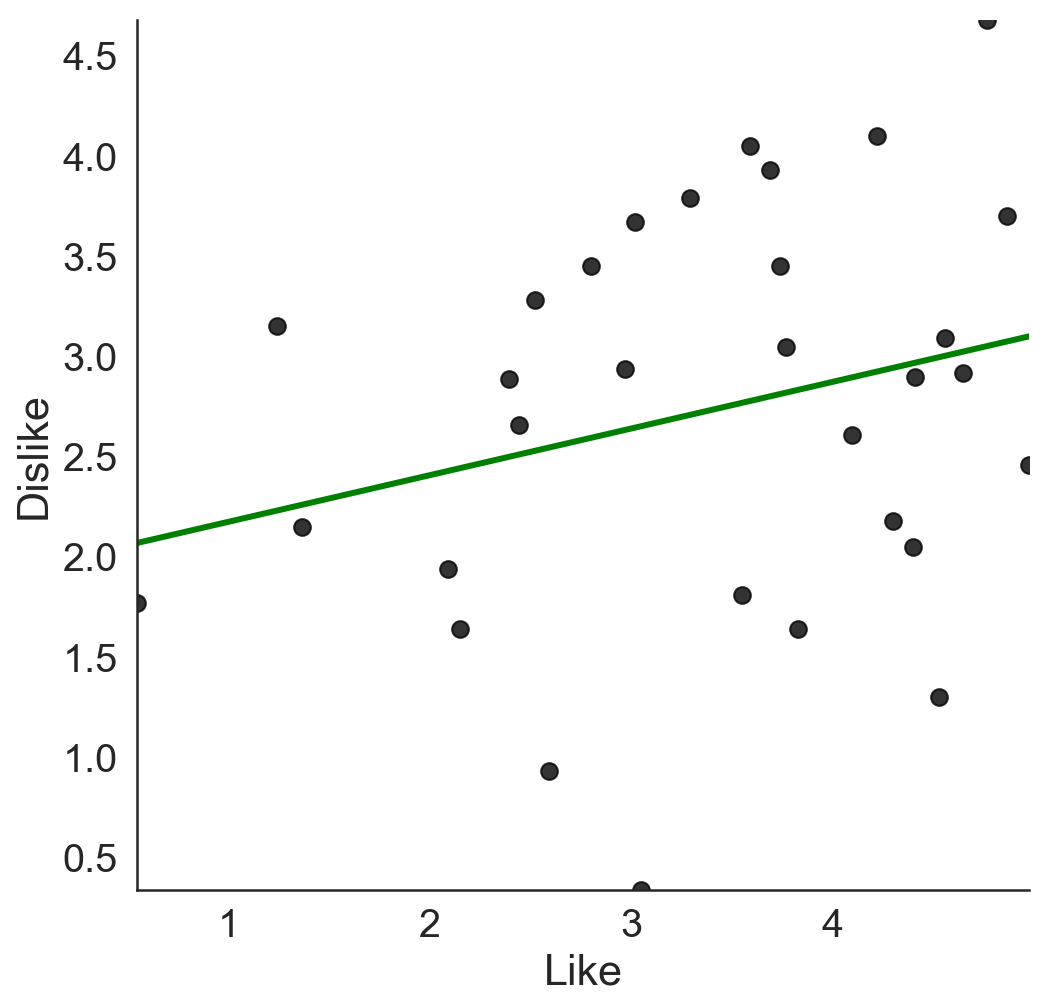

In [34]:
LD_Tau =  pd.DataFrame()
LD_Tau['Dislike'] =  D_params_part.tau
LD_Tau['Like'] =  L_params_part.tau
correl_plot(LD_Tau,'Like', "Like",'Dislike','Dislike')

Pearson's r = 0.514 p =  0.003


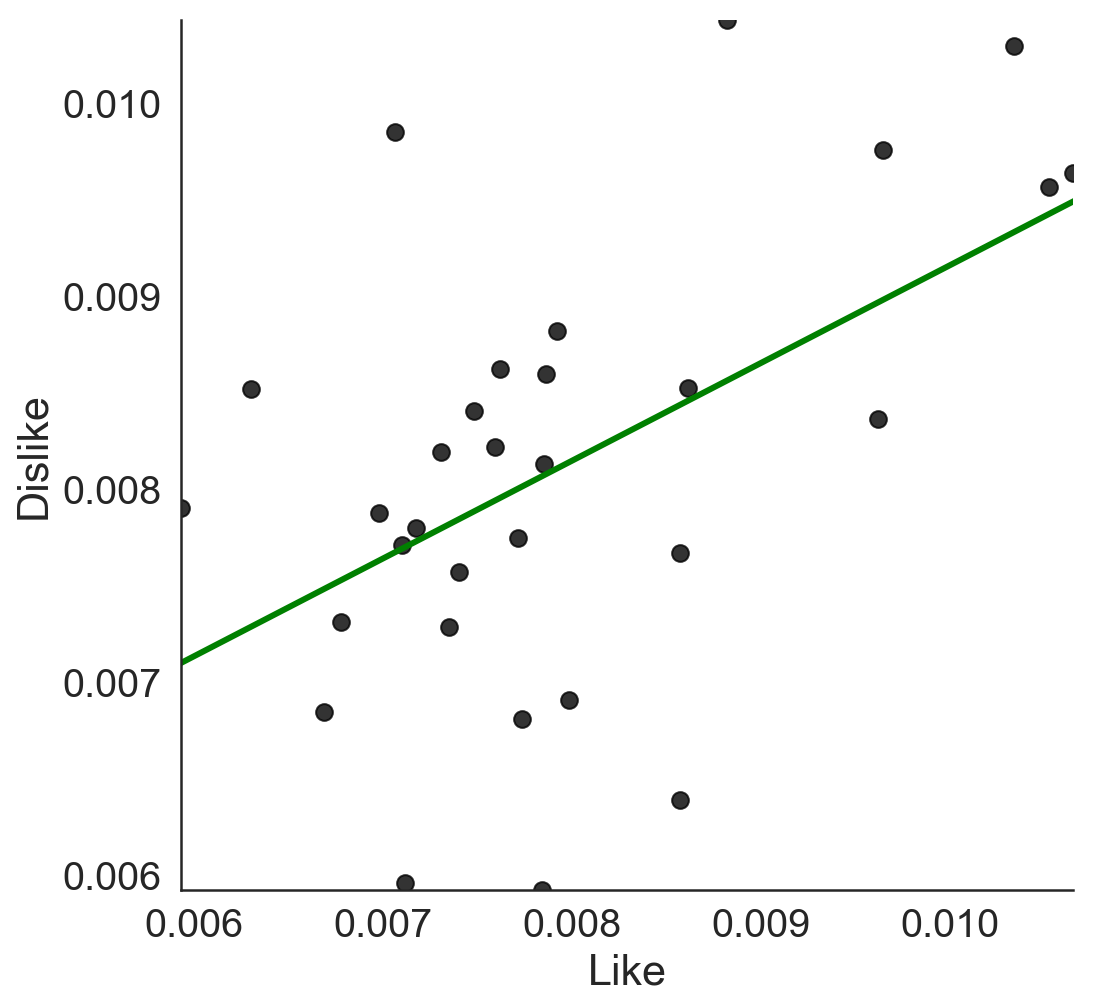

In [35]:
LD_S =  pd.DataFrame()
LD_S['Dislike'] =  D_params_part.s
LD_S['Like'] =  L_params_part.s
correl_plot(LD_S,'Like', "Like",'Dislike','Dislike')

Pearson's r = 0.687 p =  0.0


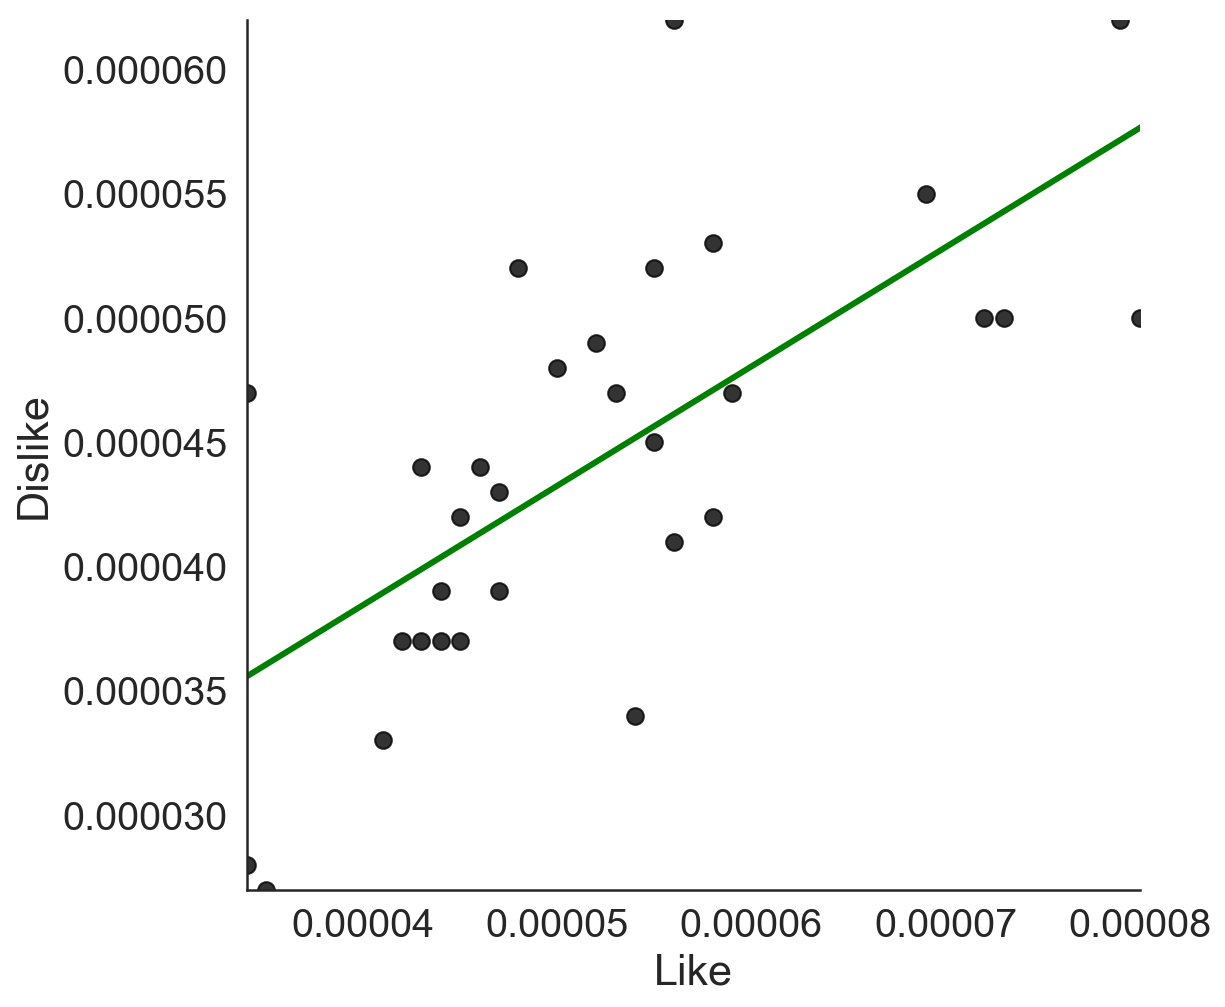

In [36]:
LD_V =  pd.DataFrame()
LD_V['Dislike'] =  D_params_part.v
LD_V['Like'] =  L_params_part.v
correl_plot(LD_V,'Like', "Like",'Dislike','Dislike')

---------------------------------